In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Subset

from torchvision.transforms import v2
import torchvision.utils as vutils
from torchvision import datasets

In this document we will explore a number of difference GANs. All have the aim to produce new samples of hand-written MNIST digits. We will start easy with the model of Goodfellow (2016) and gradually we will update the model to more advanced architectures.

1) Regular GAN (Goodfellow, 2016)
2) Regular GAN with convolutional layers
3) Wasserstein GAN (Arjovsky, 2017)
4) Wasserstein GAN with convolutional layers


We start off by loading the MNIST data and transform them. Due to the fact that we work on a CPU, we limit the data to 60_000 samples to keep the computations managable.

In [5]:
batch_size = 128

centering_fun = lambda x: x.view(-1) - 0.5

transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

num_samples = 60000
indices = np.random.choice(len(train_data), num_samples, replace=False)
train_subset = Subset(train_data, indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2, shuffle=False)

In [3]:
data, target = next(iter(train_loader)) # Not sure why this takes so long..

In [6]:
sample = data[0].numpy()

sample.shape, sample.min(), sample.max()

((1, 28, 28), np.float32(0.0), np.float32(1.0))

First we make the discriminator. This is the network that should be able to distinguish the items from the original dataset from fake generated data. It should resemble a function $D:x\to(0,1)$ In this case, $x$ are vectors that describe a number in the MNIST dataset.

The 

In [7]:
noise_dimension = 64

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)
    

# Generator class
class Generator(nn.Module):
    """"""
    def __init__(self, z_dimension):
        super(Generator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(z_dimension, 128), # or 128?
            nn.LeakyReLU(0.1),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 784),
            nn.LeakyReLU(0.1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.network(z).view(-1, 1, 28, 28)

Below we define a discriminator network using convolutional layers

In [8]:
lr = 3e-4
epochs = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lossfunction = nn.BCELoss()

generate = Generator(noise_dimension).to(device)
discriminate = Discriminator().to(device)

optimizer_gen = optim.Adam(generate.parameters(), lr=lr)
optimizer_disc = optim.Adam(discriminate.parameters(), lr=lr)

Here we code the training loop.

$$E_{x\sim p_{data}}\log D(x) + E_{z\sim p_{z}}\log(1- D(G(z)))$$

The left expectation is the real part, the right expectation is called the fake part

BCELoss $(x,y) = \frac{1}{n}\sum_{i=1}^n[y_i\log(x_i) +(1-y_i)\log(1-x_i)]$

In [ ]:
K = 2
epochs = 50

for epoch in range(epochs):
    # Total number of loops

    # Initialize cumulative loss values for the epoch
    total_batches = len(train_loader)
    running_loss_disc = 0.0
    running_loss_gen = 0.0

    for k in range(K):
        # Update the generating distribution K times before a single update of the discriminator

        for batch in train_loader:
            # Apply minibatch gradient descent
            # Generate fake images for updating the generator
            optimizer_disc.zero_grad()

            batch_size = batch[0].size(0)
            real_images = batch[0].to(device) ###########################

            noise = torch.randn(batch_size, noise_dimension, device=device)           #             z
            fake_images = generate(noise)                                             #           G(z)

            fake_images_disc = discriminate(fake_images.detach())                     #         D(G(z))
            real_images_disc = discriminate(real_images)

            # Make some helper values that help selecting the correct part of BCELoss
            y_ones = torch.ones(batch_size, 1, device=device)
            y_zeros = torch.zeros(batch_size, 1, device=device)
            
            # Computing the loss function (As in Algorithm 1 in Goodfellow)
            loss_data = lossfunction(real_images_disc, y_zeros)                       # E log D(x)
            loss_generated = lossfunction(fake_images_disc, y_ones)                   # E log(1-D(G(z))
            loss_discriminator = loss_data + loss_generated

            # Update the discriminator using 'loss'.
            loss_discriminator.backward()
            optimizer_disc.step()

            running_loss_disc += loss_discriminator.item()
            
    # Update the generator using newly generated 
    for i, batch in enumerate(train_loader):
        
        optimizer_gen.zero_grad()

        noise = torch.randn(batch_size, noise_dimension, device=device)
        fake_images = generate(noise)
        fake_images_disc = discriminate(fake_images)

        # Compute loss of the discriminator
        loss_generator = lossfunction(fake_images_disc, y_zeros)
        loss_generator.backward()
        optimizer_gen.step()

        running_loss_gen += loss_generator.item()

    avg_loss_disc = running_loss_disc / (K * total_batches)
    avg_loss_gen = running_loss_gen / total_batches

    # Display the epoch progress
    progress = (epoch + 1) / epochs * 100
    print(f"Epoch [{epoch + 1}/{epochs}] - {progress:.2f}% complete | "
          f"Discriminator Loss: {avg_loss_disc:.4f} | Generator Loss: {avg_loss_gen:.4f}")
    


Epoch [1/50] - 2.00% complete | Discriminator Loss: 0.0591 | Generator Loss: 0.0394
Epoch [2/50] - 4.00% complete | Discriminator Loss: 0.1798 | Generator Loss: 0.1662
Epoch [3/50] - 6.00% complete | Discriminator Loss: 0.1473 | Generator Loss: 0.0351
Epoch [4/50] - 8.00% complete | Discriminator Loss: 0.1355 | Generator Loss: 0.1090
Epoch [5/50] - 10.00% complete | Discriminator Loss: 0.0498 | Generator Loss: 0.1468
Epoch [6/50] - 12.00% complete | Discriminator Loss: 0.0873 | Generator Loss: 0.4993
Epoch [7/50] - 14.00% complete | Discriminator Loss: 0.0836 | Generator Loss: 0.1088
Epoch [8/50] - 16.00% complete | Discriminator Loss: 0.1511 | Generator Loss: 0.3205
Epoch [9/50] - 18.00% complete | Discriminator Loss: 0.0746 | Generator Loss: 3.0873
Epoch [10/50] - 20.00% complete | Discriminator Loss: 0.0760 | Generator Loss: 0.3766
Epoch [11/50] - 22.00% complete | Discriminator Loss: 0.0408 | Generator Loss: 0.0399
Epoch [12/50] - 24.00% complete | Discriminator Loss: 0.0631 | Gene

After 50 epochs the sampled digits start representing digits, beautiful!

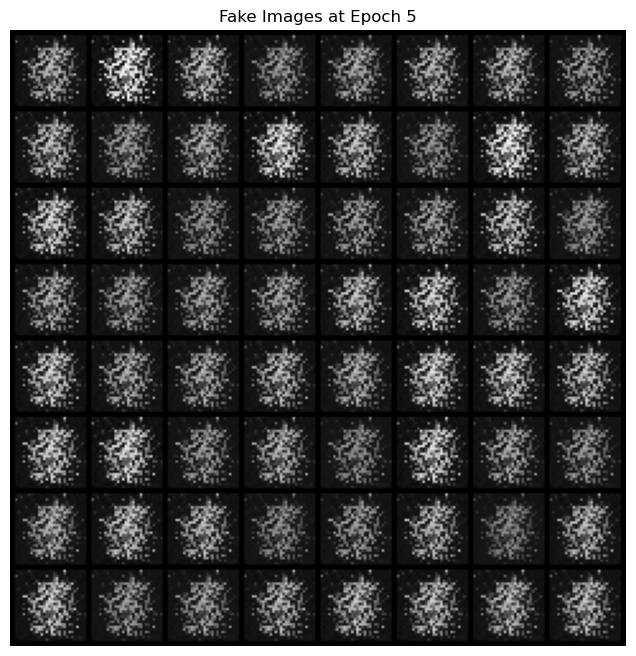

In [15]:
plt.figure(figsize=(8, 4))
plt.axis("off")
plt.title(f"Fake Images at Epoch {epoch + 1}")
plt.imshow(vutils.make_grid(fake_images[:4*8], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0)))
plt.show()

Above, both the discriminator and the generator are fully connected NN's. For image data, it may be more interesting to make the discriminator into a convolutional NN, and the generator a deconvolutional neural net.

$$D:R^{784}\to[0,1]$$
$$G:R^{32}\to X \subseteq R^{784}$$

Where $X$ is the image-space.

For convolutional networks, we use a different transformer. First of all, we use RandomAffine to augment data. All pixels can be shifted up and down by a range of 10% of the pixels. They can also be rotated and should still resemble a digit. We also transform the digit values to the interval [0,1] rather than [-0.5, 0.5] by applying a monotonic bijective mapping $\varphi(x)=2x+1$ such that $\varphi([-0.5, 0.5])=[0,1]$.

In [ ]:
batch_size = 128

transform = v2.Compose([
    v2.ToImage(), 
    v2.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: 2*x - 1)] 
    )

train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

# Getting a subset of the data for speed purposes
num_samples = 60000
indices = np.random.choice(len(train_data), num_samples, replace=False)
train_subset = Subset(train_data, indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Both networks are kept quite small. The discriminator consists of three convolutional layers but we generate up to 64 channels. The generator uses inverted convolution to upsample the 

In [20]:
# Discriminator class
class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1), 
            # nn.BatchNorm2d(64),
            # nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(), 
            nn.Linear(1024, 1), 
            
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)
    

# Generator class
class GeneratorConv(nn.Module):
    def __init__(self, z_dimension):
        super(GeneratorConv, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(z_dimension, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 7, 7)),  # 7 because it divides 28 (mnist resolution)

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),

            nn.Tanh()  
        )

    def forward(self, z):
        return self.network(z)

class GAN(nn.Module):
    pass
    def __init__(self, generator, discriminator, latent_dimension, lossfunction):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.lossfunction = lossfunction
        self.latent_dimension = latent_dimension #?


    def forward_discriminator(self):
        pass

    def forward_generator(self):
        pass

    def forward(self):
        self.forward_discriminator()
        self.forward_generator()

    def save_parameters(self):
        torch.save(self.generator.state_dict(), "generate_1.pth")
        torch.save(self.discriminator.state_dict(), "discriminate_1.pth")

    def print_layer_summary(self):
        summary(model=self.generator, input_size=(1, self.latent_dimension))
        summary(model=self.discriminator, input_size=(1, 28, 28))

    def plot_training_loss(self):
        plt.plot(discriminate_loss[0:])
        plt.plot(generate_loss[0:])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(["Discriminator", "Generator"])
        plt.show()

In [23]:
batch_size = 128

transform = v2.Compose([ # transform is anders
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)])

train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

# Getting a subset of the data for speed purposes
num_samples = 60000
indices = np.random.choice(len(train_data), num_samples, replace=False)
train_subset = Subset(train_data, indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2, shuffle=False)

In [24]:
lr = 3e-4
epochs = 1

generate = GeneratorConv(noise_dimension).to(device)
discriminate = DiscriminatorConv().to(device)

optimizer_gen = optim.Adam(generate.parameters(), lr=lr)
optimizer_disc = optim.Adam(discriminate.parameters(), lr=lr)

In [25]:
K = 2
epochs = 5

for epoch in range(epochs):
    # Total number of loops

    # Initialize cumulative loss values for the epoch
    total_batches = len(train_loader)
    running_loss_disc = 0.0
    running_loss_gen = 0.0

    for k in range(K):
        # Update the generating distribution K times before a single update of the discriminator

        for batch in train_loader:
            # Apply minibatch gradient descent
            # Generate fake images for updating the generator
            optimizer_disc.zero_grad()

            batch_size = batch[0].size(0)
            real_images = batch[0].to(device) ###########################

            noise = torch.randn(batch_size, noise_dimension, device=device)           #             z
            fake_images = generate(noise)                                             #           G(z)

            fake_images_disc = discriminate(fake_images.detach())                     #         D(G(z))
            real_images_disc = discriminate(real_images)

            # Make some helper values that help selecting the correct part of BCELoss
            y_ones = torch.ones(batch_size, 1, device=device)
            y_zeros = torch.zeros(batch_size, 1, device=device)
            
            # Computing the loss function (As in Algorithm 1 in Goodfellow)
            loss_data = lossfunction(real_images_disc, y_zeros)                       # E log D(x)
            loss_generated = lossfunction(fake_images_disc, y_ones)                   # E log(1-D(G(z))
            loss_discriminator = loss_data + loss_generated

            # Update the discriminator using 'loss'.
            loss_discriminator.backward()
            optimizer_disc.step()

            running_loss_disc += loss_discriminator.item()
            
    # Update the generator using newly generated 
    for i, batch in enumerate(train_loader):
        
        optimizer_gen.zero_grad()

        noise = torch.randn(batch_size, noise_dimension, device=device)
        fake_images = generate(noise)
        fake_images_disc = discriminate(fake_images)

        # Compute loss of the discriminator
        loss_generator = lossfunction(fake_images_disc, y_zeros)
        loss_generator.backward()
        optimizer_gen.step()

        running_loss_gen += loss_generator.item()

    avg_loss_disc = running_loss_disc / (K * total_batches)
    avg_loss_gen = running_loss_gen / total_batches

    # Display the epoch progress
    progress = (epoch + 1) / epochs * 100
    print(f"Epoch [{epoch + 1}/{epochs}] - {progress:.2f}% complete | "
          f"Discriminator Loss: {avg_loss_disc:.4f} | Generator Loss: {avg_loss_gen:.4f}")
    


ValueError: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 16])) is deprecated. Please ensure they have the same size.

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title(f"Fake Images at Epoch {epoch + 1}")
plt.imshow(vutils.make_grid(fake_images[:64], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0)))
plt.show()